# Image Coloration 

Le but de ce travail est de transformer une image au niveau de gris en une image en couleur


In [ ]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 30kB/s 
     |████████████████████████████████| 6.8MB 36.5MB/s 
     |████████████████████████████████| 460kB 36.7MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [ ]:
print(tf.__version__)

NameError: ignored

# Fetch data

In [ ]:
!wget https://www.floydhub.com/api/v1/download/artifacts/data/MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true&path=images

--2020-08-06 17:55:58--  https://www.floydhub.com/api/v1/download/artifacts/data/MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true
Resolving www.floydhub.com (www.floydhub.com)... 104.26.0.30, 104.26.1.30, 172.67.72.144, ...
Connecting to www.floydhub.com (www.floydhub.com)|104.26.0.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true’

MiXqoqaWLFhA5TNjJCi     [         <=>        ] 681.18M  13.9MB/s    in 50s     

2020-08-06 17:56:49 (13.5 MB/s) - ‘MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true’ saved [714270720]



In [ ]:
!tar -xf "/content/MiXqoqaWLFhA5TNjJCiwoQ?is_dir=true" 

# Import des librairies

In [ ]:
import tensorflow as tf
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave,imread, imshow, imread_collection, concatenate_images
import numpy as np
import os
import random
import tensorflow as tf

# Recuperation d'une centaine d'images pour constituer le Train

In [ ]:
path_to_train = "/content/images/Train/"
cpt = 0 
for elem in os.listdir(path_to_train):
  if cpt < 2000 : 
    os.rename(path_to_train + elem , "/content/Data/"+elem)
    cpt = cpt + 1 


# Chargement et preprocessing

* Normalisation des images 
* Scaling des images en 256 * 256 
* Passage du rgb au lab 


In [ ]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory("/content/images", 
                                          target_size=(256, 256),
                                          class_mode=None)

#Convert from RGB to Lab
X =[]
Y =[]
cpt = 0 
for img in train[0]:
  if cpt < 100 : 
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0]) 
        Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
        #so we divide the values by 128 to restrict values to between -1 and 1.
        cpt = cpt +1
    except:
      print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)


Found 6088 images belonging to 2 classes.
(32, 256, 256, 1)
(32, 256, 256, 2)


# Approche par autoencodeur: Encodage par des couches de convolutions  + deconvolution layers ( Up Sampling) 

* Les fonctions d'activations sont des reLU sauf pour la sortie (tanh)
* Le decodage est basé sur le UpSampling des images

modele plus gros 

In [ ]:
# Building the neural network
def define_network() : 
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
  model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
  
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(UpSampling2D((2, 2)))
  # Finish model
  model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])
  print(model.summary())
  return model

model = define_network()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_205 (Conv2D)          (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 32, 32, 512)     

# Entrainement 

In [ ]:
#Train the neural network
history = model.fit(x=X, y=Y,validation_split=0.1, batch_size=16, epochs=15)
print(model.evaluate(X, Y, batch_size=1))

Epoch 1/15
2/6 [=========>....................] - ETA: 1s - loss: 0.5291 - accuracy: 0.5247WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1176s vs `on_train_batch_end` time: 0.2143s). Check your callbacks.


6/6 [==============================] - 2s 354ms/step - loss: 0.8332 - accuracy: 0.4333 - val_loss: 0.5875 - val_accuracy: 0.3968
Epoch 2/15
6/6 [==============================] - 2s 314ms/step - loss: 0.2981 - accuracy: 0.4610 - val_loss: 0.0118 - val_accuracy: 0.3453
Epoch 3/15
6/6 [==============================] - 2s 314ms/step - loss: 0.0114 - accuracy: 0.5468 - val_loss: 0.0071 - val_accuracy: 0.6051
Epoch 4/15
6/6 [==============================] - 2s 315ms/step - loss: 0.0096 - accuracy: 0.5730 - val_loss: 0.0070 - val_accuracy: 0.6051
Epoch 5/15
6/6 [==============================] - 2s 312ms/step - loss: 0.0096 - accuracy: 0.5730 - val_loss: 0.0069 - val_accuracy: 0.6051
Epoch 6/15
6/6 [==============================] - 2s 314ms/step - loss: 0.0096 - accuracy: 0.5730 - val_loss: 0.0068 - val_accuracy: 0.6051
Epoch 7/15
6/6 [==============================] - 2s 312ms/step - loss: 0.0095 - accuracy: 0.5730 - val_loss: 0.0068 - val_accuracy: 0.6051
Epoch 8/15
6/6 [===============

100/100 [==============================] - 1s 15ms/step - loss: 0.0098 - accuracy: 0.5641
[0.00984032079577446, 0.5641075372695923]


# Sauvegarde

In [ ]:
model.save('autoencoder.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: autoencoder.model/assets


INFO:tensorflow:Assets written to: autoencoder.model/assets


# Courbe d'evaluation

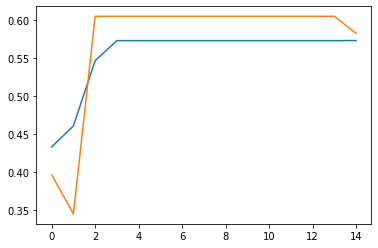

In [ ]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


# Presentation des images

In [ ]:
img_test = img_to_array(load_img('/content/0PQeZ8.jpg'))
img_test = resize(img_test ,(256,256))
img1_color=[]
img1_color.append(img_test)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
imsave("result.png", lab2rgb(result))

#Image en couleur

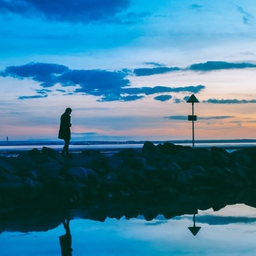

In [ ]:
from IPython.display import Image
Image('/content/0PQeZ8.jpg')

#Image en gris

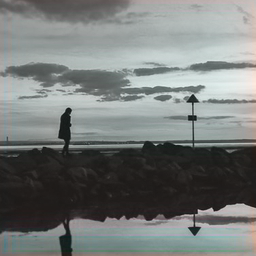

In [ ]:
Image('result.png')


# Chargement du dataset

# Transfer Learning à partir d'un ResNet 18 

Le resultat précédent, bien que pouvant etre améliorer en rajoutant des images, est toutefois limité. 
En concatenant l'autoencodeur avec un ResNet18, on fournit au modele une idée des couleurs des objets. 

__Par exemple, on sait qu'il y a peu de chances qu'un chien soit vert facilitant le coloriage.__ 

# Preproccesing

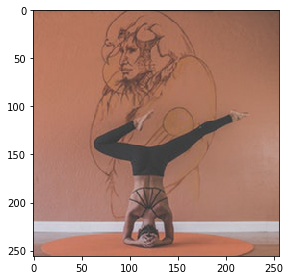

In [ ]:
from matplotlib import pyplot as plt 
imshow(X_train[10])
plt.show()

### Backbone : Le ResNet sert de classifier

In [ ]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('/content/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph =  tf.compat.v1.get_default_graph()

# Checkpoint

In [ ]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential() 
#num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False. 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [ ]:
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(32, 256, 256, 1)
(32, 256, 256, 2)


In [ ]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,256,256,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((8,8,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(32, 8, 8, 512)


In [ ]:
np.shape(X)

(32, 256, 256, 1)

In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()


model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=700, batch_size=2)

model.save('colorize_autoencoder_VGG16.model')


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_70 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_71 (UpSampling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 28, 28, 32)        18464     
_________________________________________________________________
up_sampling2d_72 (UpSampling (None, 56, 56, 32)      

16/16 [==============================] - 0s 9ms/step - loss: 0.1114 - accuracy: 0.4765
Epoch 2/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0143 - accuracy: 0.6094
Epoch 3/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0126 - accuracy: 0.5764
Epoch 4/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0111 - accuracy: 0.6139
Epoch 5/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0101 - accuracy: 0.6315
Epoch 6/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0090 - accuracy: 0.6293
Epoch 7/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0082 - accuracy: 0.6428
Epoch 8/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - accuracy: 0.6409
Epoch 9/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0066 - accuracy: 0.6474
Epoch 10/700
16/16 [==============================] - 0s 8ms/step - loss: 0.0065 - accuracy: 0.6517
Epoch 11/700
16/16 [=

In [ ]:
testpath = '/content/testdata/Train/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    imsave('images_with_vgg/result'+str(idx)+".jpg", lab2rgb(cur))

# Presentation des images

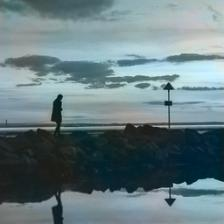

In [ ]:
from IPython.display import Image
Image('/content/images_with_vgg/result0.jpg')

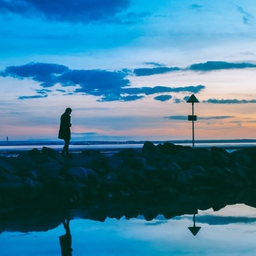

In [ ]:
Image('/content/testdata/Train/0PQeZ8.jpg')